# Importing Necessary Libraries

In [3]:
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None

import re
import nltk
# nltk.download('popular')
import spacy
import string
from nltk.tokenize import RegexpTokenizer

# About The Dataset

# Reading the Dataset

In [4]:
df = pd.read_excel("raw_data.xlsx", sheet_name="capstone_airline_reviews3")
df.dropna(subset = 'recommended', inplace = True)  # drop rows with missing values in recommended column
df.head()

airline  overall               author   review_date  \
1  Turkish Airlines      7.0  Christopher Hackley  8th May 2019   
3  Turkish Airlines      2.0        Adriana Pisoi  7th May 2019   
5  Turkish Airlines      3.0            M Galerko  7th May 2019   
7  Turkish Airlines     10.0          Zeshan Shah  6th May 2019   
9  Turkish Airlines      1.0           Pooja Jain  6th May 2019   

                                     customer_review aircraft  traveller_type  \
1  âœ… Trip Verified | London to Izmir via Istanb...      NaN        Business   
3  âœ… Trip Verified | Istanbul to Bucharest. We ...      NaN  Family Leisure   
5  âœ… Trip Verified | Rome to Prishtina via Ista...      NaN        Business   
7  âœ… Trip Verified | Flew on Turkish Airlines I...     A330    Solo Leisure   
9  âœ… Trip Verified | Mumbai to Dublin via Istan...      NaN    Solo Leisure   

           cabin                           route           date_flown  \
1  Economy Class    London to Izmir via Istanbul  2019-05-01 00:00:00   
3  Economy Class           Istanbul to Bucharest  2019-05-01 00:00:00   
5  Economy Class  Rome to Prishtina via Istanbul  2019-05-01 00:00:00   
7  Economy Class    Washington Dulles to Karachi           April 2019   
9  Economy Class   Mumbai to Dublin via Istanbul  2019-05-01 00:00:00   

   seat_comfort  cabin_service  food_bev  entertainment  ground_service  \
1           4.0            5.0       4.0            4.0             2.0   
3           4.0            1.0       1.0            1.0             1.0   
5           1.0            4.0       1.0            3.0             1.0   
7           4.0            5.0       5.0            5.0             5.0   
9           1.0            1.0       1.0            1.0             1.0   

   value_for_money recommended  
1              4.0         yes  
3              1.0          no  
5              2.0          no  
7              5.0         yes  
9              1.0          no

In [5]:
df.shape

(64440, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64440 entries, 1 to 131894
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          64440 non-null  object 
 1   overall          62530 non-null  float64
 2   author           64440 non-null  object 
 3   review_date      64440 non-null  object 
 4   customer_review  64440 non-null  object 
 5   aircraft         19717 non-null  object 
 6   traveller_type   39754 non-null  object 
 7   cabin            63302 non-null  object 
 8   route            39725 non-null  object 
 9   date_flown       39633 non-null  object 
 10  seat_comfort     60681 non-null  float64
 11  cabin_service    60715 non-null  float64
 12  food_bev         52608 non-null  float64
 13  entertainment    44193 non-null  float64
 14  ground_service   39358 non-null  float64
 15  value_for_money  63975 non-null  float64
 16  recommended      64440 non-null  object 
dtypes: float64(

In [7]:
# Checking Duplicate Rows
df.duplicated().sum()

4679

In [8]:
# Dropping Duplicate Rows
df.drop_duplicates(inplace = True)

In [9]:
# Checking Null Values
df.isnull().sum()[df.isnull().sum() > 0] * 100 / df.shape[0]

overall             2.951758
aircraft           69.065109
traveller_type     37.184786
cabin               1.768712
route              37.229966
date_flown         37.360486
seat_comfort        5.940329
cabin_service       5.891802
food_bev           19.109453
entertainment      32.681849
ground_service     37.803919
value_for_money     0.726226
dtype: float64

#### Observations:
- We shall drop the `aircraft` column since it has approx 70% null values.
- We shall also drop the `date_flown` column since it is irrelevant to our analysis.

In [10]:
df.drop(columns=['aircraft', 'date_flown'], inplace=True)

In [11]:
df.shape

(59761, 15)

In [12]:
# Furthermore, we shall drop the rest of the rows containing null values
df.dropna(inplace=True)

In [13]:
# Resetting index
df.reset_index(drop=True, inplace=True)

In [14]:
# Checking shape again
df.shape

(22826, 15)

# Exploratory Data Analysis

In [15]:
df.head(2)

airline  overall               author   review_date  \
0  Turkish Airlines      7.0  Christopher Hackley  8th May 2019   
1  Turkish Airlines      2.0        Adriana Pisoi  7th May 2019   

                                     customer_review  traveller_type  \
0  âœ… Trip Verified | London to Izmir via Istanb...        Business   
1  âœ… Trip Verified | Istanbul to Bucharest. We ...  Family Leisure   

           cabin                         route  seat_comfort  cabin_service  \
0  Economy Class  London to Izmir via Istanbul           4.0            5.0   
1  Economy Class         Istanbul to Bucharest           4.0            1.0   

   food_bev  entertainment  ground_service  value_for_money recommended  
0       4.0            4.0             2.0              4.0         yes  
1       1.0            1.0             1.0              1.0          no

## 1. Airlines
- Analyzing top 15 airlines with most number of reviews

In [16]:
print(f"Number of Distinct Airlines: {df['airline'].nunique()}")

Number of Distinct Airlines: 81


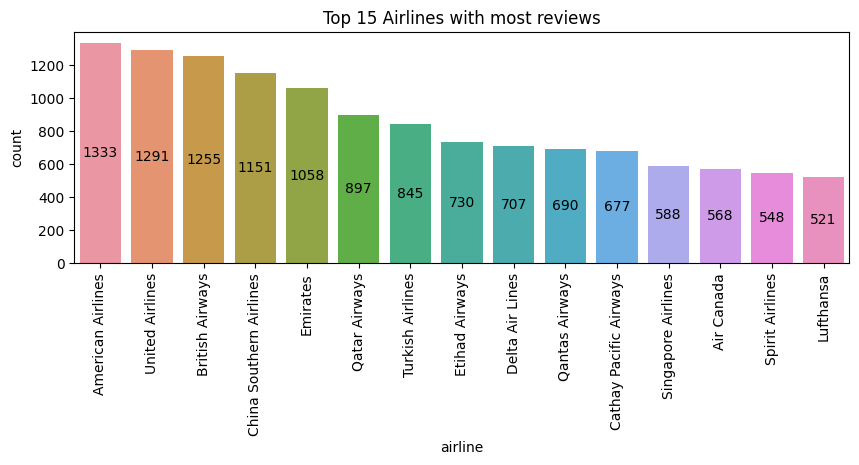

In [17]:
# Visualizing top 15 airlines based on the number of reviews
plt.figure(figsize=(10,3))
ax = sns.countplot(x='airline', data=df, order=df['airline'].value_counts().iloc[:15].index)

for label in ax.containers:
    ax.bar_label(label, label_type='center')
    
plt.title('Top 15 Airlines with most reviews')
plt.xticks(rotation=90)
plt.show()

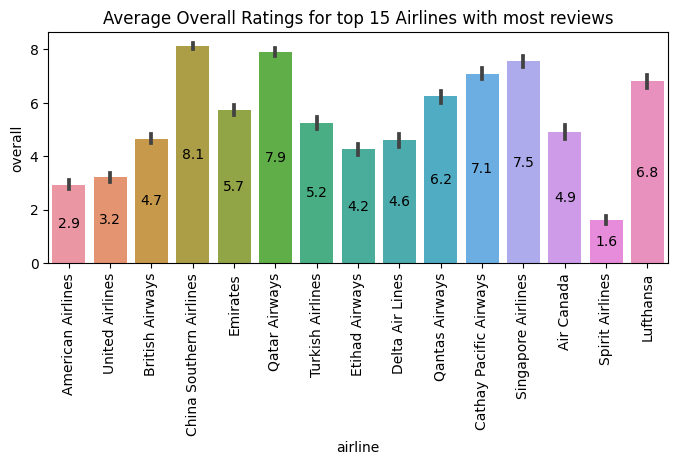

In [18]:
# Plotting average overall ratings for the top 15 airlines with most reviews
plt.figure(figsize=(8,3))
ax = sns.barplot(x='airline', y='overall', data=df, order=df['airline'].value_counts().iloc[:15].index)

for label in ax.containers:
    ax.bar_label(label, label_type='center', fmt='%.1f')

plt.title('Average Overall Ratings for top 15 Airlines with most reviews')
plt.xticks(rotation=90)
plt.show()

## 2. Author
- Analyzing authors who posted most number of reviews

In [19]:
print(f"Number of Distinct Reviewers: {df['author'].nunique()}")

Number of Distinct Reviewers: 17833


In [20]:
# Top 10 reviewers
df['author'].value_counts().iloc[:10]

Michel Perrin       48
Anders Pedersen     46
T Eldem             40
John Curtain        39
Neil Jeram          39
Alwaleed Althani    35
R Sanyal            30
Bojan Tercon        28
Rajan Parrikar      27
L Pearce            27
Name: author, dtype: int64

#### Observations:
- Using `author` column we can make a mild assumption of how often does a person flies. We shall create a new column called `frequency` based on this assumption.

## 3. Traveller_type

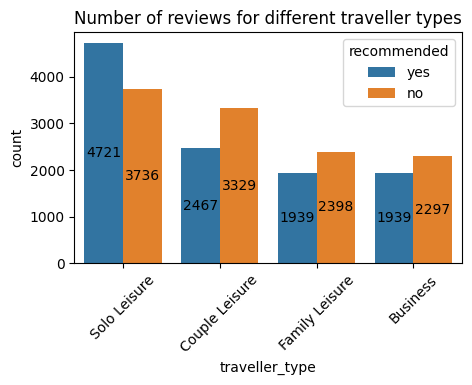

In [21]:
# Plotting number of reviews for different traveller types
plt.figure(figsize=(5,3))
ax = sns.countplot(data=df, x='traveller_type', hue='recommended', order=df['traveller_type'].value_counts().index)

for label  in ax.containers:
    ax.bar_label(label, label_type='center')
    
plt.title('Number of reviews for different traveller types')
plt.xticks(rotation=45)
plt.show()

#### Observations:
- Most of the reviewers were `Solo Leisure` travellers.
- It should also be observed that `Solo Leisure` travellers are more likely to positively recommend the airline.

## 4. Cabin

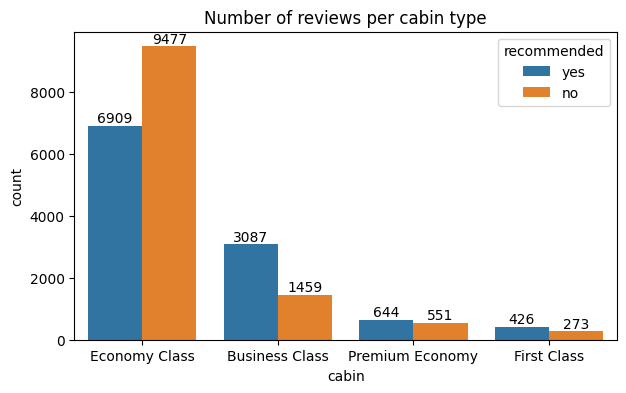

In [22]:
# Plotting Number of reviews per cabin type
plt.figure(figsize=(7,4))
ax = sns.countplot(data=df, x='cabin', hue='recommended', order=df['cabin'].value_counts().index)

for label  in ax.containers:
    ax.bar_label(label, label_type='edge')
    
plt.title('Number of reviews per cabin type')
plt.show()

#### Observations:
- Most Number of reviewers travelled in `Economy` class.
- `Business` class travellers are far more likely to positively recommend the airlines as compared to others.

## 5. Ratings

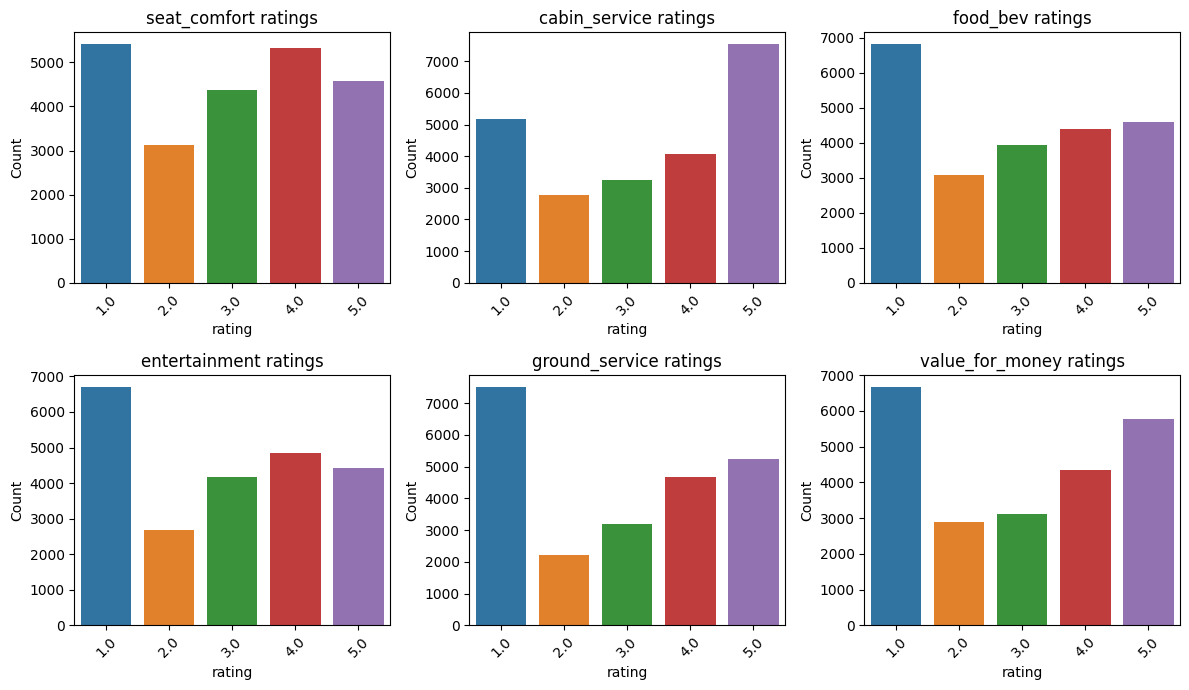

In [23]:
# Creating a subplot to showcase frequency distribution of various ratings.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
axs = axs.flatten()

rating_cols = ['seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money']

for i, col in enumerate(rating_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
    axs[i].set_title(f'{col} ratings')
    axs[i].set_xlabel('rating')
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

### Observations: (for all airlines)
- `Seat comfort` ratings seem to be average. 
- `Cabin service` seems to be good overall since passengers have mostly given 5 rating. This may vary from airline to airline.
- `Food_beverage`, `Entertainment` and `Ground`services need to improve quite a lot since psaaengers have predominantly given 1 rating out of 5.
- Most of the people seem to believe that the airline services overall do not provide `value for money`.

## 6. Overall Ratings 

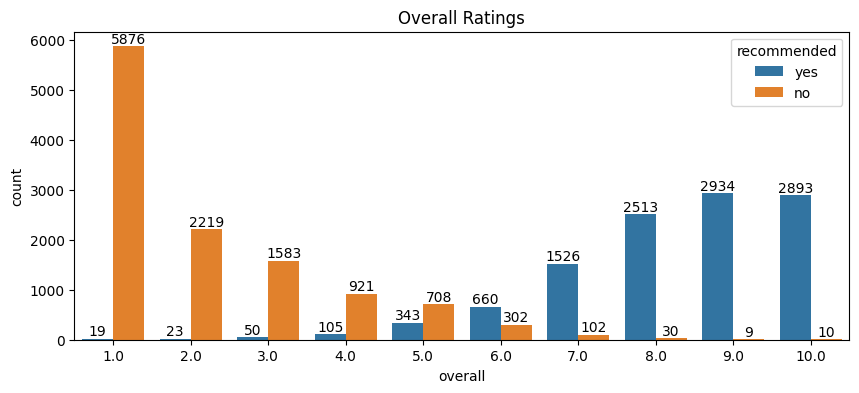

In [30]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=df, x="overall", hue="recommended")
for label  in ax.containers:
    ax.bar_label(label, label_type='edge')

plt.title("Overall Ratings")
plt.show()

### Observations:
- Overall Ratings seems to be a great measure to analyze how likely a passenger is to recommend the airline.
- For the most part we can easily say that a passenger that gives a rating greater than 5 is quite likely to recommend the airline, but there seems to be a gray area, especially in the range of (3.0 - 7.0) where people may or may not recommend the airline based on the ratings.
- To clarify this gray area we shall further analyze the passenger reviews by performing sentiment analysis and combine their outputs.

# Feature Engineering

## 1. User Flight Frequency
- Using `author` column we shall create a new feature called `frequency` which denoted how often does a user fly.

In [73]:
df['author'].value_counts()

Michel Perrin        48
Anders Pedersen      46
T Eldem              40
John Curtain         39
Neil Jeram           39
                     ..
Leonie Burns          1
H Miyagi              1
D Korn                1
M Donnelson           1
Anatoli Chernyaev     1
Name: author, Length: 17833, dtype: int64

In [74]:
# Classifying users based on their flight frequency
high = list(df["author"].value_counts()[df["author"].value_counts() >= 20].index)
med = list(df["author"].value_counts()[(df["author"].value_counts() >= 10) & (df["author"].value_counts() < 20)].index)
low = list(df["author"].value_counts()[df["author"].value_counts() < 10].index)

print(f"High freq cust = {len(high)}")
print(f"med freq cust = {len(med)}")
print(f"low freq cust = {len(low)}")

High freq cust = 19
med freq cust = 40
low freq cust = 17774


In [75]:
def freq(name):
    if name in high:
        return "Often"
    elif name in med:
        return "Occasionally"
    else:
        return "Rarely"
    
# Creating a new column called 'frequency'
df["frequency"] = df["author"].apply(lambda x : freq(x))

## 2. Type of Flight
- Using `route` column we can identify if the user had a direct or an indirect flight.
- If the `route` string contains the the word `via`, we shall classify that flight as indirect flight.

In [76]:
df['type_of_flight'] = np.where(df['route'].str.contains('via'), 'Indirect', 'Direct')

In [77]:
df['type_of_flight'].value_counts()

Direct      14069
Indirect     8757
Name: type_of_flight, dtype: int64

In [78]:
# Dropping Route column
df.drop(columns=['route'], inplace=True)

## 3. Classifying Airlines with less than 70 reviews as 'Other'

In [79]:
others = list(df["airline"].value_counts()[df["airline"].value_counts() <= 70].index)
others

['Eurowings',
 'Copa Airlines',
 'Royal Air Maroc',
 'Virgin America',
 'Pegasus Airlines',
 'AirAsia',
 'Bangkok Airways',
 'IndiGo',
 'Air Arabia',
 'TAROM Romanian',
 'airBaltic',
 'Thai Smile Airways',
 'Tunisair',
 'Adria Airways',
 'Germanwings',
 'QantasLink']

In [80]:
# Defining a function to rename airlines present in 'others' list to 'other'.
def airline(name):
    if name in others:
        return "other"
    else:
        return name
    
df["airline"] = df["airline"].apply(lambda x : airline(x))

In [81]:
df["airline"].value_counts()

American Airlines          1333
United Airlines            1291
British Airways            1255
China Southern Airlines    1151
Emirates                   1058
                           ... 
South African Airways        91
Brussels Airlines            79
Egyptair                     77
flydubai                     73
easyJet                      72
Name: airline, Length: 66, dtype: int64

# Rearranging columns and finalizing our clean dataset

In [82]:
cols = ['review_date', 'author', 'airline', 'traveller_type', 'cabin' , 'type_of_flight', 'frequency', 'seat_comfort',
       'cabin_service', 'food_bev', 'entertainment', 'ground_service',
       'value_for_money', 'overall', 'customer_review', 'recommended']

# Preparing final dataframe
df = df.loc[:, cols]

In [83]:
df.head()

review_date               author           airline  traveller_type  \
0  8th May 2019  Christopher Hackley  Turkish Airlines        Business   
1  7th May 2019        Adriana Pisoi  Turkish Airlines  Family Leisure   
2  7th May 2019            M Galerko  Turkish Airlines        Business   
3  6th May 2019          Zeshan Shah  Turkish Airlines    Solo Leisure   
4  6th May 2019           Pooja Jain  Turkish Airlines    Solo Leisure   

           cabin type_of_flight frequency  seat_comfort  cabin_service  \
0  Economy Class       Indirect    Rarely           4.0            5.0   
1  Economy Class         Direct    Rarely           4.0            1.0   
2  Economy Class       Indirect    Rarely           1.0            4.0   
3  Economy Class         Direct    Rarely           4.0            5.0   
4  Economy Class       Indirect    Rarely           1.0            1.0   

   food_bev  entertainment  ground_service  value_for_money  overall  \
0       4.0            4.0             2.0              4.0      7.0   
1       1.0            1.0             1.0              1.0      2.0   
2       1.0            3.0             1.0              2.0      3.0   
3       5.0            5.0             5.0              5.0     10.0   
4       1.0            1.0             1.0              1.0      1.0   

                                     customer_review recommended  
0  âœ… Trip Verified | London to Izmir via Istanb...         yes  
1  âœ… Trip Verified | Istanbul to Bucharest. We ...          no  
2  âœ… Trip Verified | Rome to Prishtina via Ista...          no  
3  âœ… Trip Verified | Flew on Turkish Airlines I...         yes  
4  âœ… Trip Verified | Mumbai to Dublin via Istan...          no

# Performing basic text cleaning on 'customer_review' column

In [84]:
df['customer_review'].sample(10)

3797     âœ… Trip Verified | I was flying out of Atlant...
18374    Athens to Montreal with Air Canada rouge. The ...
3969     Not Verified | We have flown American Airlines...
10985    â Unverified | Denpasar to Vancouver via Sha...
14138    Qantas from Sydney to Manila, and Bangkok to S...
1667     Great service and attention on these Qatar Air...
16324    âœ… Verified Review | On my first flight from ...
16552    âœ… Trip Verified | Flew Singapore Airlines fr...
7751     âœ… Trip Verified | MalÃ© to Zurich via Moscow...
9109     There was no in-flight entertainment. Even the...
Name: customer_review, dtype: object

In [85]:
# Splitting the reviews on '|' and keeping only the review portion
def basic_cleaning(review):
    split_review = review.split('|')
    if len(split_review) > 1:
        return split_review[1].strip()
    else:
        return split_review[0].strip()
    
df['customer_review'] = df['customer_review'].apply(lambda x : basic_cleaning(x))

In [86]:
df['customer_review'].sample(10)

11372    Toronto to Guangzhou, it is a very popular cho...
4877     We purchased first class seats to fly New York...
3491     Flew from London to Los Angeles via Amsterdam....
21532    Icelandair is okay in business class, but refu...
13829    Sydney to Bangkok 14 June. Having flown with t...
12159    Auckland to London via Guanghzou return with C...
4207     Harrisburg to Philadelphia. This was the worst...
13975    Sydney to Brisbane. It was quite a smooth flig...
14524    Los Angeles to Paris CDG in First Class, conne...
3912     Norfolk to Honolulu via Dallas Ft Worth. Best ...
Name: customer_review, dtype: object

# Cleaning Reviews
- Steps to be followed:
    - convert all text to `lowercase`.
    - remove all `whitespaces` at the beginning and end of text.
    - remove all `html tags`, `unicode characters`, `emojis`.
    - remove all `twitter usernames` if they exist.
    - remove all `punctuations` and `numbers` except `'` and `-`, since we shall expand acronyms and contractions.
    - replace `-` with whitespaces.
    - expand `acronymns` and `contractions`.
    - remove all `punctuations` again.
    - `lemmatize` using spacy lemmatizer.
    - remove `stopwords`.
    - keep only `alphabets` and `whitespace`.
    - remove words with one alphabet occuring more than 3 times continuously.
    - remove words with less than 3 characters.
- Further cleaning steps shall be applied if needed.

## Defining a function to preprocess text by following above steps

In [87]:
# Defining acronyms and contractions
acronyms_dict = pd.read_json("stopwords/acronym.json", typ="series")
contractions_dict = pd.read_json("stopwords/contractions.json", typ="series")

In [88]:
# getting unique airline names
[airline.split()[0].lower() for airline in df['airline'].unique()]

['turkish',
 'qatar',
 'emirates',
 'lufthansa',
 'klm',
 'other',
 'american',
 'delta',
 'southwest',
 'united',
 'jetblue',
 'aegean',
 'aeroflot',
 'aeromexico',
 'air',
 'air',
 'alitalia',
 'asiana',
 'avianca',
 'austrian',
 'british',
 'brussels',
 'china',
 'china',
 'ethiopian',
 'egyptair',
 'finnair',
 'iberia',
 'ana',
 'easyjet',
 'korean',
 'latam',
 'lot',
 'qantas',
 'air',
 'etihad',
 'royal',
 'ryanair',
 'south',
 'saudi',
 'tap',
 'eva',
 'singapore',
 'sas',
 'swiss',
 'thai',
 'air',
 'air',
 'air',
 'air',
 'cathay',
 'wizz',
 'spirit',
 'vueling',
 'sunwing',
 'flydubai',
 'garuda',
 'frontier',
 'icelandair',
 'aer',
 'alaska',
 'norwegian',
 'gulf',
 'kuwait',
 'wow',
 'ukraine']

In [89]:
# Defining stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe", "ï", "ûï", "â€™"]
common_words = ["flight", "fly", "airline", "via", "tell"]
airline_names = [airline.split()[0].lower() for airline in df['airline'].unique()]
stops = alphabets + others + common_words + airline_names
stops = list(set(stops))

In [90]:
regexp = RegexpTokenizer("[\w']+")
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    
    # lowercase
    text = text.lower()
    
    # remove whitespaces
    text = text.strip()
    
    # removing html tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)
    
    # removing emoji patterns
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', text) 
    
    # removing urls
    http = "https?://\S+|www\.\S+"
    pattern = r"({})".format(http)
    text = re.sub(pattern, "", text)
    
    # removing twitter usernames if they exist
    pattern = r'@[\w_]+'
    text = re.sub(pattern, "", text)
    
    # Removing punctuations and numbers except ' and -
    punct_str = string.punctuation + string.digits
    punct_str = punct_str.replace("'", "")
    punct_str = punct_str.replace("-", "")
    text = text.translate(str.maketrans('', '', punct_str))
    
    # Replacing "-" in text with empty space
    text = text.replace("-", " ")
    
    # Substituting acronyms
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_dict.index:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()
    text = ' '.join(words)                                                                                       # acronyms
    
    # Substituting Contractions
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_dict.index:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()
    text = " ".join(words)
    
    # Removing punctuations again
    punct_str = string.punctuation
    text = text.translate(str.maketrans('', '', punct_str))
    
    # Lemmatization using spacy
    text = " ".join([token.lemma_ for token in nlp(text)])
    
    # Stopwords removal
    text = ' '.join([word for word in regexp.tokenize(text) if word not in stops]) 
    
    # Removing words with one alphabet occuring more than 3 times continuously
    pattern = r'\b\w*?(.)\1{2,}\w*\b'
    text = re.sub(pattern, "", text).strip()
    
    # Removing words with less than 3 characters
    pattern = r'\b\w{1,2}\b'
    text = re.sub(pattern, "", text).strip()
    
    # Removing all characters except alphabets and " " (space)
    filter_text = string.ascii_letters + " "
    text = "".join([chr for chr in text if chr in filter_text])
    
    # Replacing multiple spaces with one single space
    pattern = r'\s+'
    text = re.sub(pattern, " ", text).strip()
    
    # Removing certain POS tags from the text
    remove_tags = ['PROPN', 'DET', 'CCONJ', 'PRON', 'AUX']
    text = " ".join([token.text for token in nlp(text) if token.pos_ not in remove_tags])
    
    # return final output
    return text

In [91]:
text = df.loc[11248, 'customer_review']
print(text)
print("---------------------------------------------------------------------------------------------------")
print(preprocess(text))

Guangzhou to Auckland. Very nice welcome at check in, boarding pass issued and a brief wait and then the flight boarded early. Got to Auckland slightly ahead of schedule. Staff give extremely good service during the flight. Food is about average, seats are comfortable. IFE has great selections in different language. No frills, no fuss, great service. Highly recommended airline for international travel.
---------------------------------------------------------------------------------------------------
very nice welcome check boarding pass issue brief wait then board early get auckland slightly ahead schedule staff give extremely good service during food about average seat comfortable ife have great selection different language frill fuss great service highly recommend for international travel


In [92]:
text = df.loc[18248, 'customer_review']
print(text)
print("---------------------------------------------------------------------------------------------------")
print(preprocess(text))

Lisbon to Toronto. Not much leg space, had to purchase better seats for extra $100 per seat per leg of travel. For in-flight entertainment you need to download an app prior to boarding. We did but it still didnâ€™t work. No charging plugs if the seat is in the 1st row of economy cabin. Flight attendants friendly. Ordered special low sodium meals and got a wrap loaded with salt. Poor experience compared to regular Air Canada.
---------------------------------------------------------------------------------------------------
not much leg space purchase well seat for extra per seat per leg travel for entertainment need download app prior boarding still didn work charge plug seat row economy cabin attendant friendly order special low sodium meal get wrap load with salt poor experience compare regular


In [93]:
df["review_clean"] = df["customer_review"].apply(lambda x : preprocess(x))

In [94]:
df[['customer_review', 'review_clean', 'recommended']].sample(10)

customer_review  \
5602   I fly quite a bit so I think I have a balanced...   
19382  London to Manila via Hong Kong return with Cat...   
16808  Moscow to Sydney via Singapore with Singapore ...   
15597  Flew Royal Jordanian Airlines from Amman to Pa...   
938    Hyderabad to Doha. I want to thank Qatar Airwa...   
12487  Flew Ethiopian Airlines from Mumbai - Cape Tow...   
2118   Dubai to Karachi. It was a very bad experience...   
10634  These British Airways flights were undoubtedly...   
5425   I am so disappointed with my treatment this ev...   
18353  Barcelona to Toronto. I had never flown Air Ca...   

                                            review_clean recommended  
5602   quite bit think balanced view fair service ret...          no  
19382  return with particular aircraft quite new ther...         yes  
16808  with airlines airplane have technical issue le...          no  
15597  from efficient polite while disorganize airpla...         yes  
938    want thank airway for quality crew give treat ...         yes  
12487  from mumbai cape town check mumbai smooth drea...         yes  
2118   very bad experience emirate when need change d...          no  
10634  airways undoubtedly bad ever have ten year tra...          no  
5425   disappointed with treatment evening partner bo...          no  
18353  never before very long without screen sure ren...          no

In [95]:
cols = ['review_date', 'author', 'airline', 'traveller_type', 'cabin', 'type_of_flight', 'frequency', 'seat_comfort',
       'cabin_service', 'food_bev', 'entertainment', 'ground_service',
       'value_for_money', 'overall', 'customer_review', 'review_clean', 'recommended']

# Preparing final dataframe
df = df.loc[:, cols]

In [96]:
df.head(2)

review_date               author           airline  traveller_type  \
0  8th May 2019  Christopher Hackley  Turkish Airlines        Business   
1  7th May 2019        Adriana Pisoi  Turkish Airlines  Family Leisure   

           cabin type_of_flight frequency  seat_comfort  cabin_service  \
0  Economy Class       Indirect    Rarely           4.0            5.0   
1  Economy Class         Direct    Rarely           4.0            1.0   

   food_bev  entertainment  ground_service  value_for_money  overall  \
0       4.0            4.0             2.0              4.0      7.0   
1       1.0            1.0             1.0              1.0      2.0   

                                     customer_review  \
0  London to Izmir via Istanbul. First time Iâ€™d...   
1  Istanbul to Bucharest. We make our check in in...   

                                        review_clean recommended  
0  first time find very good cabin crew plane foo...         yes  
1  make check airport take luggage gate gate surp...          no

# Saving the dataframe in a sql database

In [97]:
# Creating a connection to the database
connection = sqlite3.connect('data.db')

# Creating a table to save cleaned data
df.to_sql(name='airline_reviews', con=connection, if_exists='replace', index=False)

# Closing the connection to the database
connection.close()